# <center> Automatic license plate recognition.





## Task description and introduction to the data.





### Case Description


Security has become one of the biggest concerns for any organization these days, and automating that security is essential. For example, in the modern world, companies and organizations want to automate many tasks related to control and monitoring as much as possible. However, many of the existing solutions are still not reliable in real situations, usually subject to many constraints.

As a CV-case, we propose to create a part of an automatic license plate recognition system for vehicles.

<img src= "https://focuscontrol.info/media/digivod-Marktführer-in-Kennzeichenerkennung.jpg" width="550" align="right"  hspace="5%" vspace="5%"/>

***Automatic (or automated) license-plate recognition (ALPR)*** is the identification of the part of the vehicle that is supposed to be a license plate. In other words, it is an artificial intelligence technology that uses optical character recognition in images to read vehicle registration plates to generate vehicle location data.

This technology typically uses traffic enforcement cameras or cameras specifically designed for this task. 


ALPR technology is applied in many areas, here are some examples:
* in parking lots to fix license plates of parked cars;
* at checkpoints (checkpoints) for fixing license plates of vehicles entering and leaving the territory of the enterprise;
* law enforcement forces for law enforcement purposes on the roads to identify vehicles that violate traffic rules or to check whether the vehicle has a registration or license;
* for traffic control and electronic toll collection on toll roads, e.g. by traffic agencies.

<img src= "https://github.com/Asikpalysik/Automatic-License-Plate-Detection/blob/main/Presentation/Notebook2.png?raw=true" width="50%" align="center"  hspace="5%" vspace="5%"/>

In general, to identify a vehicle's license plate, the following steps must be followed:
1. **License plate detection on image.**

    At this stage, we need to develop an algorithm that will be responsible for finding and highlighting the license plate in the image.
    If we translate the task into terms of Computer Vision, then, in fact, at this stage we need to build a model that solves the detection problem - highlighting the location of the license plate in the photo.

2. **License plate orientation and calibration.**

    At this stage, the license plate skew is compensated and the resulting image is resized to the required size.

3. **Normalization.**
    
    At this stage, the brightness and contrast of the image are adjusted to increase the likelihood of correct recognition of text in the photo.
4. **Character segmentation.**
    At this stage, we need to find individual characters on license plates. That is, in fact, you need to break the text in the image into separate characters. In the case of printed text, where there is always some space between characters, this is a fairly simple task. But for handwritten text, everything is much more complicated, here it is already required to involve specialized methods, but now it’s not about them.

    The figure below shows examples of steps 2-4:
    <img src= "https://upload.wikimedia.org/wikipedia/commons/9/9c/California_license_plate_ANPR.png" width="20%" align="center"  hspace="5%" vspace="5%"/>


5. **Optical Character Recognition.**

    When we have selected each character, we need to recognize it. And this is far from a trivial task! In essence, at this stage we are converting our license plate image into a first approximation of the text.

6. **Syntactic/geometric analysis.**

    After we have received the text, we need to check it for correctness. Characters and positions are checked for compliance with the rules of a particular country according to specialized rules
7. **Averaging of the recognized value.**

    Making decisions one frame at a time is a bad idea. The results can be severely distorted due to image quality, glare due to reflected light, incorrect camera angles, and many other reasons.
    Therefore, to obtain more accurate and reliable results, the recognition procedure (steps 1-6) is repeated several times.
    The final result of the ALPR system will be obtained by averaging the results of the algorithm over several images obtained with a certain time interval.


As you can see, building a full-fledged ALPR system is a complex and very difficult task that may require the involvement of an entire development team! The complexity of the implementation of each of the above stages determines the overall accuracy and speed of the system. In addition, at each stage, you can expect a huge number of pitfalls, depending on the conditions in which your system operates.

As part of this project, we will create a model that will allow us to find license plates on images, that is, we will implement a toolkit for performing the 1st stage of the ALPR-system algorithm. In the implementation process, we will not reinvent the wheel, but will use existing tools and libraries.

### About the dataset


To solve our problem, we need a dataset of images of cars from different angles and in different lighting conditions with license plate locations marked as bounding boxes.

Of course, it is better to assemble your own dataset that meets the conditions (lighting, location and resolution of CCTV cameras, etc.) in which your ALPR system will be used. But since our conditions are still unknown, and the customer needs to demonstrate an image of the result, we can use any suitable data set. Luckily, there are plenty of them on the internet.

For specifics, we will work with a dataset [Car License Plate Detection](https://www.kaggle.com/andrewmvd/car-plate-detection), 
hosted on our favorite Kaggle platform.

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F793761%2Fc15e812b3ab9aad2c0694a2e1f7548e9%2FUntitled.png?generation=1590981584876269&alt=media)

This dataset contains 433 unique images with license plate bounding box annotations within the image. Moreover, one image can contain several cars at once, and, accordingly, several license plates.

Abstracts are provided in PASCAL VOC format.

[**PASCAL VOC**](https://www.section.io/engineering-education/understanding-pascal-voc-dataset/) - this is such an annotation format when information about images, bounding boxes, classes, rotation and other data necessary for solving a computer vision problem is presented in the form of an XML file with fixed fields and structure. We will look at an example of such an annotation a little later, when we explore the dataset.


### Introduction to data


It is time to move on to practical implementation. As a first step, let's look at our dataset from the inside and get acquainted with its structure. 

Immediately import all the libraries that we need when solving the project:

In [1]:
# Libraries for handling tabular data
import pandas as pd
import numpy as np

# Libraries for visualization of graphs and images/
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Libraries for training models
import torch
from sklearn.model_selection import train_test_split

# Library for working with the operating system
import os
import glob

# Library for parsing XML files
import xml.etree.ElementTree as ET 

#Auxiliary bibilotheques
from tqdm.auto import tqdm
import shutil as sh

In [2]:
pip install jedi>=0.10


Next, check that we have a graphics accelerator available.

In [3]:
# Check if the graphics card is available to us
print(torch.cuda.is_available())
# Look at the name of the video card
#print(torch.cuda.get_device_name(0))

True


***Note:***

*If the result of the `cuda.is_available()` function is False, it means that you are not using a graphics card. Check that you have changed the accelerator in the Kaggle laptop settings.*

Let's first take a look at our directory structure when using the virtual resources provided by Kaggle. Let's see where we are now. Since Kaggle laptops run on the Linux operating system, bash commands are also used to execute terminal commands.


In particular, in order to see the path to the working directory, the pwd command is used:


By default, when working on a Kaggle laptop, we are in the /kaggle/working virtual directory. Next to it is the /kaggle/input directory, which contains our dataset. The dataset is in the car-plate-detection folder, and this folder contains annotations folders - it contains annotations, XML files with annotations, images - a folder with images.

The general folder structure can be represented as follows:
```
kaggle
    └─input
        └─car-plate-detection
            └─annotations
            └─images
    └─working
        └─__notebook_source__.ipynb
```

Давайте для удобства зададим глобальные переменные с путями до нужных нам папок:

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# Path to folder with dataset
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/cars_number_plate"
# Path to the folder with annotations
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
# Path to folder with images
IMAGES_PATH = os.path.join(DATASET_PATH, "images")

print(ANNOTATIONS_PATH)
print(IMAGES_PATH)

/content/drive/MyDrive/Colab Notebooks/cars_number_plate/annotations
/content/drive/MyDrive/Colab Notebooks/cars_number_plate/images


Let's look at an example image. To display an image on the screen, use the function [imshow()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) from the matplotlib library. To read an image, you must pass the path to the image into it. The path can be relative (relative to the working directory) or absolute (set relative to the project root directory).


The result of reading will be a numpy array of dimensions (HEIGHT, WIDTH, CHANNEL), where:
* HEIGHT - height of images (in pixels)
* WIDTH - width of images (in pixels)
* CHANNEL - number of channels

All images in the dataset are color, that is, they have three channels (consists of three two-dimensional matrices) - RGB (Red, Green, Blue). The values ​​of each of the three matrices are pixel intensity values.


Image shape: (398, 530, 3)


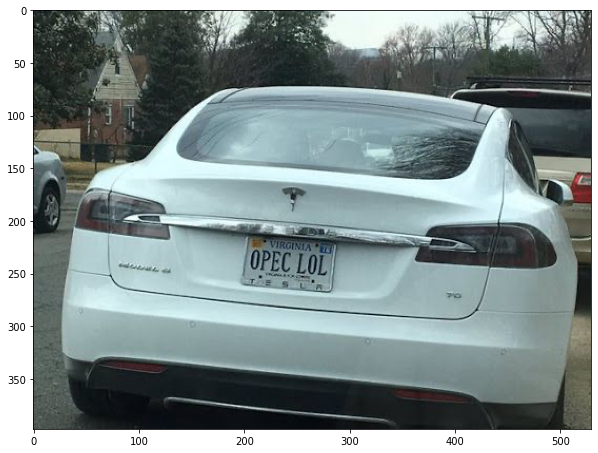

In [6]:

# Compose the path to the file - /path/to/folder/image_name.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Read the image
img = plt.imread(image_path)
# Create a figure and a coordinate plane
fig, ax = plt.subplots(figsize=(10, 8))
# Display the image on the screen
ax.imshow(img);
# Display image size
print('Image shape: {}'.format(img.shape))

**Note:**

*When read by the matplotlib library, pixel intensity is measured from 0 to 1, where 1 corresponds to 255 for the standard image format.
You can verify this yourself by displaying the read image on the screen as an array:*

In [7]:
#print(img)

**Now** let's look at an example annotation for this image.

In [8]:
# Read one of the annotated files and look at the contents
with open(os.path.join(ANNOTATIONS_PATH, 'Cars129.xml')) as f:
    print(f.read())


<annotation>
    <folder>images</folder>
    <filename>Cars129.png</filename>
    <size>
        <width>530</width>
        <height>398</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>204</xmin>
            <ymin>213</ymin>
            <xmax>282</xmax>
            <ymax>267</ymax>
        </bndbox>
    </object>
</annotation>


When using the PASCAL VOC format annotation, the following tags are specified:
* `<annotation>` - root title
    * `<folder>` - image folder
    * `<filename>` - file name
    * `<size>` - size information
        * `<width>` - width
        * `<height>` - height
        * `<depth>` - depth (number of channels)
    * `<segmented>` - this field contains information for segmentation. That is, do the images contain annotations of a non-linear (irregular) shape, usually called polygons (we don’t have those, all frames are rectangular, so the value is 0)
    * `<object>` - information for object detection
        * `<name>` is the name of the class (in our case, the license plate).
        * `<pose>` - sets the asymmetry or orientation of the image. By default, it is listed as Unspecified, which means that the image is not distorted.
        * `<truncated>` - indicates whether the object is fully or partially visible (can be 0 or 1 respectively)
        * `<occluded>` - information about the absorption of classes by each other (this is when inside the bounding box of class A, there is a bounding box of class B)
        * `<difficult>` - Indicates whether it is difficult to recognize the object in the image (can be 0 - easy or 1 - difficult).
        * `<bndbox>` are coordinates that define the location of an object (in our case, a car's license plate).
        These coordinates are contained in the child tags `<xmin>, <ymin>, <xmax>, <ymax>`. The annotation stores the coordinates of the top left and bottom right positions of the object.

Note that the coordinate system used for images is somewhat different from what we're used to: the vertical Y-axis originates from the top left corner of the image and points down. That is, the annotation above defines the following bounding box of the image:
<img src= "https://i.ibb.co/nMcHpgB/2023-02-04-17-31-07.png" width="40%" align="center"  hspace="5%" vspace="5%"/> 


Let's create a DataFrame for further convenience, in which we will store the following columns:
* `filename` - file name (without extension)
* `xmin`, `xmax` - minimum and maximum coordinates of the frame along the x axis
* `ymin`, `ymax` - the minimum and maximum coordinates of the frame along the y axis
* `width`, `height` - image width and height

To do this, we use the following code to parse XML files with annotations:

In [9]:
# Initialise the dictionary, then create a DataFrame based on it
df_dict = {
    "filename":[], "xmin":[], "ymin":[],   
    "xmax":[],"ymax":[], "name":[],    
    "width":[], "height":[],
}

# Create a loop on all annotations from 
for annotation in glob.glob(ANNOTATIONS_PATH+"/*.xml"):
    # Read the XML file with the annotation
    tree = ET.parse(annotation)
    # Find the tag corresponding to the file name
    filename = tree.find('filename').text
    # Create a loop through all elements of the XML file
    for elem in tree.iter():
        # Retrieve image size information from the annotation - width and height
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    
        # get the picture information - the class name and the bounding box coordinate information 
        if 'object' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text                 
                    df_dict['name'] += [name]
                    df_dict['width'] += [width]
                    df_dict['height'] += [height] 
                    df_dict['filename'] += [filename]
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            df_dict['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            df_dict['ymin'] += [ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            df_dict['xmax'] += [xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            df_dict['ymax'] += [ymax]


After executing this code, we get the dictionary we need and convert it to a DataFrame:

In [10]:
df = pd.DataFrame(df_dict)
df.head()

,filename,xmin,ymin,xmax,ymax,name,width,height
0,Cars1.png,134,128,262,160,licence,400,248
1,Cars0.png,226,125,419,173,licence,500,268
2,Cars101.png,167,202,240,220,licence,400,300
3,Cars103.png,230,129,248,134,licence,400,196
4,Cars103.png,189,116,202,121,licence,400,196


Now it will be very convenient for us to analyse the characteristics of our dataset. Let's look at the number of records (annotations), unique number of images and unique classes in the data:

In [11]:
print('Data shape: {}'.format(df.shape))
print('Count of unique images: {}'.format(df['filename'].nunique()))
print('Count of classes: {}'.format(df['name'].unique()))


Data shape: (471, 8)
Count of unique images: 433
Count of classes: ['licence']


We see that we have a total of 471 annotations, but there are fewer unique images - 433. This means that one image can have several number plates at once. This is an important feature of the dataset! 


We can also see that we have only one class in the data - licence (number plate). This means that when performing detection, we will solve the problem of binary classification - distinguish the class of the number plate from the background (everything which is not a number plate).

<img src= "https://i.ibb.co/C8TMH8H/2023-02-04-17-33-33.png" width="40%" align="right" hspace="5%" vspace="5%"/> 
Now that we have sparred the coordinates of the bounding boxes let's select some image from the dataset and display it along with the annotation. So let's add a bounding box on top of the image. 


To do that let's use the [Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) class from the patches module of matplotlib library. It allows us to define a rectangle and display it on the chart (image). To define a rectangle, you must specify the following parameters:


* Mandatory:
    * xy - coordinates of the bottom left corner on the image (in pixels);
    * Width and height - width and height of the rectangle; 
* Optional:
    * linewidth - width of the line drawn in the rectangle;
    * edgecolor - colour of the bounding box, take red;
    * facecolor - inner fill colour, as we don't need it, we set the parameter to 'none';

From the annotations we know the coordinates of the upper left corner of the bounding box (they are specified by the xmin and ymin columns) and the coordinates of the lower right corner (xmax and ymax). To calculate the width of a rectangle we use a simple geometry formula:
$$w = x_{max}-x_{min}$$
$$h = y_{max} - y_{min}$$$

Also keep in mind that there can be several bounding boxes for one picture, so for correct visualization we need to loop through all coordinates corresponding to the picture.
The final code will look like this:

[204] [213] [78] [54]


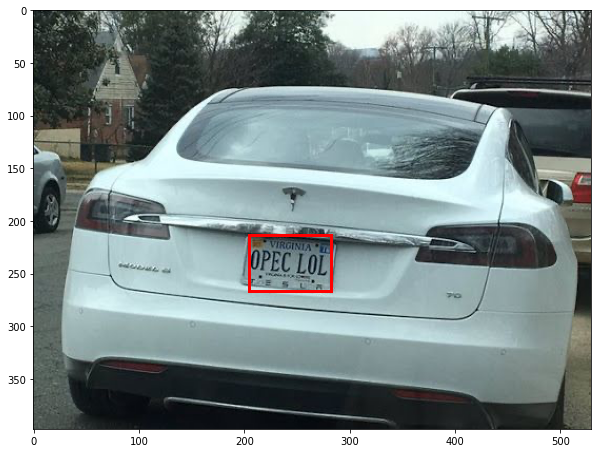

In [12]:
# Make a path to the file - /path/folder/image_name.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# read the image
img = plt.imread(image_path)
# create shape and coordinate plane
fig, ax = plt.subplots(figsize=(10, 8))
# print the image
ax.imshow(img);

# find the index of the image in the DataFrame
image_idx = df[df['filename'] == image_filename].index

# Find coordinates of the left bottom point
x_min = df.loc[image_idx, 'xmin'].values
y_min = df.loc[image_idx, 'ymin'].values
# find the width and height of the box
box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
print(x_min, y_min, box_width, box_height)

# because there can be several boxes, we create a loop for all of them
for i in range(len(image_idx)):
    # build a rectangle
    rect = patches.Rectangle(
        (x_min[i], y_min[i]), # Coordinates of anchor point
        box_width[i], #width of the rectangle
        box_height[i], #height of the rectangle
        linewidth=3, #width of the line
        edgecolor='r', #color
        facecolor='none' #fill (none - none)
    )
    # superimpose rectangle on top of image
    ax.add_patch(rect);

Let's wrap this whole shroud of code for image rendering as a function, let's call it `plot_bounding_box()` for further convenience. The function will take the name of the file with the desired image and the DataFrame with coordinates and display the image on the screen.

In [13]:
def plot_bounding_box(image_folder, image_filename, df=df):
    # Create a full path to the image
    image_path = os.path.join(image_folder, image_filename)
    # read the image
    img = plt.imread(image_path)
    # create shape and coordinate plane
    fig, ax = plt.subplots(figsize=(10, 8))
    # print the image
    ax.imshow(img);

    # find the index of the image in the DataFrame
    image_idx = df[df['filename'] == image_filename].index

    # Find coordinates of the left bottom point
    x_min = df.loc[image_idx, 'xmin'].values
    y_min = df.loc[image_idx, 'ymin'].values
    # find the width and height of the box
    box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
    box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
    # because there can be several boxes, we loop through them all
    for i in range(len(image_idx)):
        # build a rectangle
        rect = patches.Rectangle(
            (x_min[i], y_min[i]), # Coordinates of anchor point
            box_width[i], #width of the rectangle
            box_height[i], #height of the rectangle
            linewidth=3, #width of the line
            edgecolor='r', #color
            facecolor='none' #fill (none - none)
        )
        # superimpose rectangle on top of image
        ax.add_patch(rect);

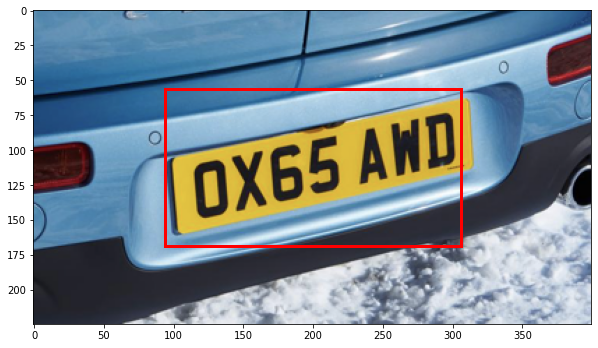

In [14]:
plot_bounding_box(image_folder=IMAGES_PATH, image_filename='Cars33.png', df=df)

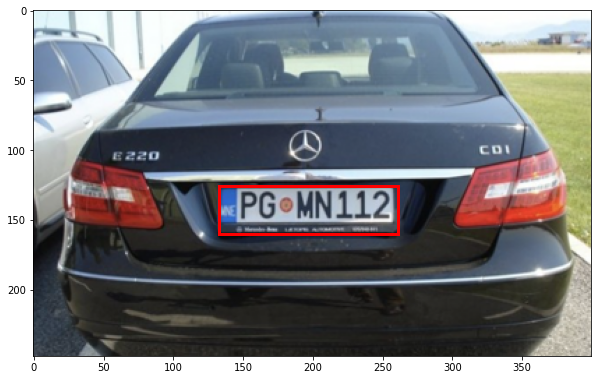

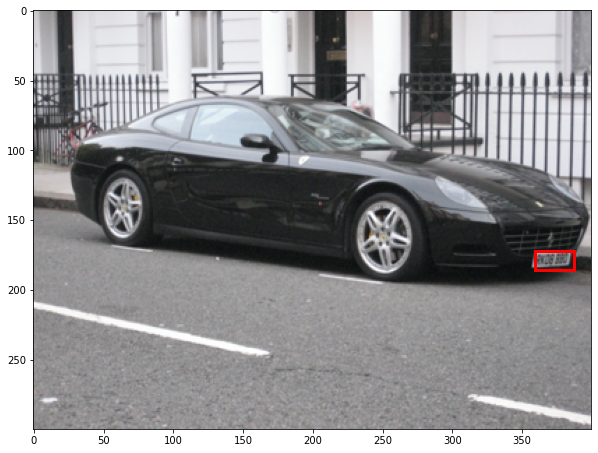

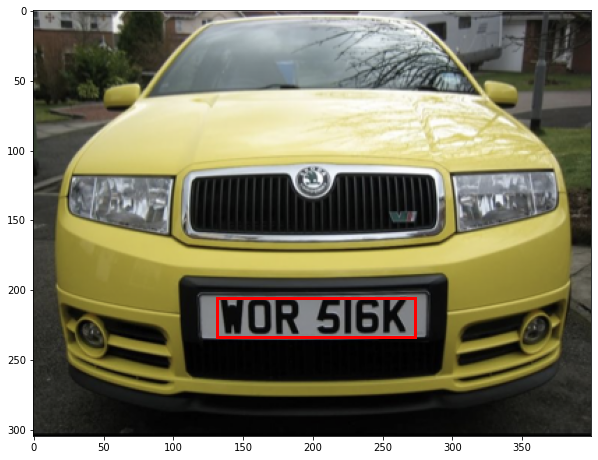

In [15]:
count = 3
for i in range(count):
    random_image_idx = np.random.choice(df.shape[0])
    image_filename = df.loc[random_image_idx, 'filename']
    plot_bounding_box(IMAGES_PATH, image_filename, df)

## Select the model and prepare the data

In the world of computer vision, for every task, be it classification, detection or image generation, there are specific solution methods (specific neural network architectures). However, for every neural network architecture there are dozens of implementations. Each implementation, in its turn, requires a certain format of input data to be used. 

So the preprocessing of input data depends on the architecture of the model and the implementation we choose.

## Selecting a model

So, we have already decided that at the first stage of building an algorithm for ALPR-system operation we solve the problem of detection - extraction of the location of the object of interest from the image, in our case - the number plate of the vehicle. 

As we have already discussed, there are at least two classes of models for solving the detection problem: one-stage and two-stage. Nowadays the most popular and the most precise models are the ones of the YOLO family.

**What is YOLO?

>*YOLO (abbr. from "You Only Look Once")** is a modern deep learning method for object detection tasks (both detection and segmentation) based on convolutional neural networks. 
The first version of the algorithm was developed in 2016 and as of early 2023, there are already at least 8 common modifications of this model, each with its own advantages and disadvantages. So YOLO is a whole family of neural network architectures for detection and segmentation tasks!

The key idea of YOLO is that the original image is divided into small sections (called cells/samples/tiles) of size SxS pixels (S can be different for different versions of YOLO).

Each resulting one becomes a potential bounding_box. That is, inside each cell, using a special method, several frames are "drawn" to define an object of varying width and height (and it's also possible to add rotation), and the positions of these frames are calculated relative to the centre of the cell.

On the resulting sections, a probability distribution map of each class in each section is constructed using a specialized convolutional neural network architecture, i.e. the probability of each class being present in each section is determined. After that the results are combined in a specialized way and we get a solution to the detection problem - the bounding boxes we need.

A general (top-level) scheme of how YOLO works is shown in the figure below:
<img src= "https://miro.medium.com/max/1400/0*Lg8T0ghKhK9XAeW4.png" width="70%" align="center" hspace="5%" vspace="5%"/> 

The main feature of YOLO architecture is speed! YOLO allows real-time recognition of objects in the image. The principle of YOLO implies input of the whole image at once, which goes through the convolutional neural network only once. That's why it's called "It only takes one look". In other algorithms, the process is repeated many times, meaning the image passes through the CNN over and over again. So YOLO has the advantage of high-speed object detection, something other algorithms cannot boast of.

And as you understand in the task of building ALPR systems, speed is one of the main criteria!

Once we have chosen a family of architectures, we still have to choose the model version. For example, for YOLO at the beginning of 2023, the latest version is YOLOv8. We won't dwell now on the differences between all versions of the model. We refer you to [this article](https://hashdork.com/ru/yolo/), which provides a general comparison of the first 5 versions of the architecture. 

Let's use version 5 of YOLO - YOLOv5 (2020) which is not the newest but combat-proven one.

<img src= "https://avatars.githubusercontent.com/u/26833451?s=200&v=4" width="10%" align="right" hspace="5%" vspace="5%"/>

Now you and I need to choose an implementation of this model, as there are, again, a great many of them on the internet and each has its own features and requirements for the input data format. Let's take [repository with YOLOv5 implementation](https://github.com/ultralytics/yolov5) on the PyTorch deep learning framework from [Ultralitics](https://ultralytics.com/) as our implementation. 


If you're wondering how YOLO and its 5th modification works from the inside, we recommend you check out the following sources :
* first to the original [article "You Only Look Once"](https://arxiv.org/pdf/1506.02640.pdf) by the creators of YOLO (YOLOv1)
* then to [this article](https://medium.com/analytics-vidhya/object-detection-algorithm-yolo-v5-architecture-89e0a35472ef) which discusses features of YOLOv5
* and finally, the repository from Ultralitics, which also has detailed tutorials on how to use the model and [description of the architecture](https://github.com/ultralytics/yolov5/issues/6998)

Now that we have chosen the model, we need to prepare our data so that we can use the model.

### Prepare data for YOLOv5 format

According to [documentation on creating custom models](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data) from Ultralitics, to feed the data into the YOLOv5 model and teach it to the user's task, a directory with images and annotations must be specially formed. 

To teach the model you need to create a data configuration file in YAML format. It specifies the paths to the folders with images and annotations that belong to the training, validation and test (optional) samples, as well as the class names. Based on this, Ultralitics' YOLOv5 will understand where to take the data files for training, validation and testing respectively.


For example, let's say we have a dataset root directory, let's call it dataset:
```
dataset
    └─dataset.yaml
    └─images
        └─train
            └─img1.png
            └─img2.png
        └─val
            └─img3.png
            └─img4.png
    └─labels
        └─train
            └─img1.txt
            └─img2.txt
        └─val
            └─img3.txt
            └─img4.txt
```

Then the configuration file for such dataset (dataset.yaml) must be in the following format:

```
path: dataset # root directory of the dataset
train: images/train # the folder with the images of the training set
val: images/val # val folder with validation sample images
test: # val folder with images of the test shots (empty)

names: # class names
  0: person
  1: bicycle
  2: car
  3: motorcycle
  ...

```
The figure below shows an example of a directory organization suitable for the YOLOv5 model:
<img src="attachment:16b73ec4-8992-4a43-a12f-48997a81eecb.png" width="50%" align="center" hspace="5%" vspace="5%"/>

Let's move on to creating the directories we talked about above. Set the paths as global variables:

In [59]:
DATA_PATH = "dataset/" # dataset root folder

LABELS_PATH = os.path.join(DATA_PATH, "labels") # Annotations folder
IMGS_PATH = os.path.join(DATA_PATH, "images") #Images folder

TRAIN_IMAGES_PATH = os.path.join(IMGS_PATH, "train") # Path to folder with training graphics
VAL_IMAGES_PATH = os.path.join(IMGS_PATH, "val") #Path to folder with validation images
TRAIN_LABELS_PATH = os.path.join(LABELS_PATH, "train") #Path to folder with training annotations
VAL_LABELS_PATH = os.path.join(LABELS_PATH, "val") #Path to folder with validation annotations

DATA_CONFIG_PATH = os.path.join(DATA_PATH, "dataset.yaml") #Path to data configuration file

print(TRAIN_IMAGES_PATH)
print(VAL_IMAGES_PATH)
print(TRAIN_LABELS_PATH)
print(VAL_LABELS_PATH)
print(DATA_CONFIG_PATH)

dataset/images/train
dataset/images/val
dataset/labels/train
dataset/labels/val
dataset/dataset.yaml


Now let's create the directories we need. To do this, use the [makedirs()](https://docs-python.ru/standart-library/modul-os-python/funktsija-makedirs-modulja-os/) function from the os module. Also, to ensure code reproducibility and avoid errors when restarting the notebook, we will check if the folders we create exist with the [path.exists()](https://docs.python.org/3/library/os.path.html) function from the same module.

In [17]:
import os

In [18]:
# Create a local folder in which to put images and annotations (if it does not already exist)
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    
# create a folder to store the training images (if it does not exist already)    
if not os.path.exists(TRAIN_IMAGES_PATH):
    os.makedirs(TRAIN_IMAGES_PATH)
# create a folder to store the training annotations for the objects (if it does not exist already)
if not os.path.exists(TRAIN_LABELS_PATH):
    os.makedirs(TRAIN_LABELS_PATH)
    
# create a folder to store validation images (if it does not already exist) 
if not os.path.exists(VAL_IMAGES_PATH):
    os.makedirs(VAL_IMAGES_PATH)
    
# create a folder to store validation annotations for objects (if it does not already exist)
if not os.path.exists(VAL_LABELS_PATH):
    os.makedirs(VAL_LABELS_PATH)

As a result of running this code, we should have a directory structure like the one we gave above. Let's check this with the Linux ls command:

In [19]:
!ls dataset
!ls dataset/images
!ls dataset/labels

dataset.yaml  images  labels
train  val
train  val


Finally, the final step in preparing the directory. Let's add a data configuration file, name it like in the example above - dataset.yaml, in it we will write all the paths we discussed above.

In [20]:
# Create the contents of the file
data_config = f'''
path: /content/drive/MyDrive/Colab Notebooks/cars_number_plate
train: images/train
val: images/val
test:
names:
    0: licence
'''

# Open a writable file that contains the configuration of the paths from which the training data will be taken
with open(DATA_CONFIG_PATH, 'w') as f:
    f.write(data_config)

# Check that everything is recorded correctly
with open(DATA_CONFIG_PATH, 'r') as f:
    print(f.read())


path: /content/drive/MyDrive/Colab Notebooks/cars_number_plate
train: images/train
val: images/val
test:
names:
    0: licence



The structure of the directories is now taken care of. 

Now we need to fill them with content - images and annotations. If everything is clear with images - we simply divide the images into two parts - training and test samples - and copy them into the new corresponding directories, then it is a bit more complicated with annotations.

Let's ask the question: how is it even possible to set a rectangle. It is logical to assume that in order to build a rectangle, you need to set its coordinates. And there are many ways to do this. However, in Object Detection, there are two most common possible practices for specifying bounding boxes:
* Specifying a bounding box relative to the upper left and lower right points of the rectangle.
    To specify such a bounding box, you need two points:
    * $(x_1, y_1)$ - coordinates of the upper left point
    * $(x_2, y_2)$ - coordinates of the upper left point
    
    <img src= "https://miro.medium.com/max/640/1*yvPdthNNOJfmcYKsDhJJtQ.webp" width="20%" align="center" hspace="5%" vspace="5%"/> 
    
* Specifying a bounding box in relation to its center
    To set such a bounding box you need the following coordinates:
    * $(x_c, y_c)$ - coordinates of the center of the rectangle
    * $w$ - width of the rectangle
    * $h$ - height of the rectangle
    
    <img src= "https://miro.medium.com/max/640/1*PbBGGN_uSFV13R_aX6FiEA.webp" width="20%" align="center" hspace="5%" vspace="5%"/> 

As you can see, it is quite easy to switch from one format to another, you just need to know some geometry from school. For example, to switch from a format relative to the upper left and lower right points to a format relative to the center of the image, we need the following ratios:
$$x_c =\frac {x_1+x_2}{2}$$
$$y_c = \frac {y_1+y_2}{2}$$
$$w = x_2-x_1$$
$$h = y_2-y_1$$

Translated with www.DeepL.com/Translator (free version)

Now that we have understood the standard formats, let's move on to the YOLOv5 format. 

For Ultralitics' YOLOv5 to work, annotations must be presented in text file format (txt). The format implies that each line of the text file is represented as:
$$n, \bar{x_c} , \bar{y_c} , \bar{w} , \bar{h} $$$

Where:
* $n$ is the class number of the object
* $\bar{x_c}$ is the relative coordinate of the centre of the object's bounding box on the Ox axis. 
    It is called relative because the source coordinate of the centre is normalized to the width of the image:
 $\bar{x_c} =\frac{x_c} {W}=\frac{x_1+x_2}{2W}$$
    where $W$ is the width of the original image (in pixels)
* $\bar{y_c}$ - relative coordinate of the object along Oy axis. Calculated by formula:
 $$\bar{y_c} =\frac{y_c}{H}=\frac{y_1+y_2}{2H}$$
    where $H$ is the width of the original image (in pixels)
* $\bar{w}$ is the relative width of the object's bounding box. 
    Calculated using the formula:
    $$\bar{w}=\frac{w}{W}=\frac{x_2-x_1}{W}$$

* $\bar{h}$$ is the relative height of the object's bounding box. 
    Calculated using the formula:
    $$\bar{h}=\frac{h}{H}=\frac{y_2-y_1}{H}$$

Basically YOLOv5 converts the image coordinate system to a scale of 0 to 1 and marks the coordinates at this scale:
<img src="https://avatars.mds.yandex.net/i?id=91134d262f52faf8f47ba0b6bab192a3-4960217-images-thumbs&n=13" width="50%" align="center" hspace="5%" vspace="5%"/>

Let's make an intermediate conclusion: essentially all we need to do is to convert from the original format of the bounding box coordinates to the new format and write them as text files.

So let's recode the classes (we only have one) and calculate the new bounding box coordinates using the formulas given above:

In [21]:
# Recode classes
df['class'] = df['name'].map({'licence': 0})

# Calculate the normalized coordinates of the bounding box centre
df['x_center'] = (df['xmin'] + df['xmax']) / (2 * df['width'])
df['y_center'] = (df['ymin'] + df['ymax']) / (2 * df['height'])
# Calculate the relative height and width of the bounding box
df['box_width'] = (df['xmax'] - df['xmin']).abs() / df['width']
df['box_height'] = (df['ymax'] - df['ymin']).abs() / df['height']

# Let's take a look at the results
df[['class','x_center','y_center','box_width','box_height']].head()

,class,x_center,y_center,box_width,box_height
0,0,0.49500,0.580645,0.3200,0.129032
1,0,0.64500,0.555970,0.3860,0.179104
2,0,0.50875,0.703333,0.1825,0.060000
3,0,0.59750,0.670918,0.0450,0.025510
4,0,0.48875,0.604592,0.0325,0.025510


Good, we have prepared the data. Before writing the new coordinates to the files, let's create a training and validation sample. 

Let's divide all the set of images available to us into two in the ratio of 90/10. Note that we may have multiple bounding boxes in one image. It means that for creating samples we need unique files, otherwise we may have the same images in the test and validation samples and the model estimate for the validation sample will not be objective:

In [22]:
# Создаем общий список названий файлов с изображениями
image_ids = list(set(df['filename']))
# Разделяем этот список на два - тренировочную и валидационную выборку
train_ids, val_ids = train_test_split(image_ids, random_state=42, test_size=0.1)
# Посмотрим на размеры выборок
print('Train shape: {}'.format(len(train_ids)))
print('Validation shape: {}'.format(len(val_ids)))

Train shape: 389
Validation shape: 44


Finally, let's fill our folders: 
* fill annotation folders with txt files in the data format we discussed above
* let's fill the image folders with images from the corresponding samples

In [23]:
# Создаем цикл по изображениям
for filename, mini in tqdm(df.groupby('filename')):
# If the current file is in the validation sample
    if filename in val_ids:
        path2save = 'val'
# Otherwise (training sample)
    else:
        path2save = 'train'
# Make a path to the file where we write the new annotation
    new_annotation_path = os.path.join(LABELS_PATH, path2save, filename[:-4] + ".txt")
# Open a writeable (w+) file in .txt format
    with open(new_annotation_path, 'w+') as f:
# Select the coordinates of the bounding box in the format required by YOLOv5
        row = mini[['class','x_center','y_center','box_width','box_height']].astype(float).values
        row = row.astype(str)
# Write the coordinates of each bounding box in the image line by line
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")
# Transfer the images from the original folder to the new folder
    sh.copy(
        os.path.join(IMAGES_PATH, filename),
        os.path.join(IMGS_PATH, path2save, filename)
    )

  0%|          | 0/433 [00:00<?, ?it/s]

Let's look at what we have. Using the [listdir()](https://docs-python.ru/standart-library/modul-os-python/funktsija-listdir-modulja-os/) function from the os module, we list the 30 files in the training sample directories `'dataset/labels/train/'` and `'dataset/images/train/'`:

In [24]:
print(os.listdir(TRAIN_LABELS_PATH)[:30])
print(os.listdir(TRAIN_IMAGES_PATH)[:30])

['Cars22.txt', 'Cars251.txt', 'Cars308.txt', 'Cars430.txt', 'Cars145.txt', 'Cars278.txt', 'Cars191.txt', 'Cars106.txt', 'Cars292.txt', 'Cars237.txt', 'Cars348.txt', 'Cars249.txt', 'Cars315.txt', 'Cars388.txt', 'Cars79.txt', 'Cars358.txt', 'Cars293.txt', 'Cars334.txt', 'Cars47.txt', 'Cars261.txt', 'Cars161.txt', 'Cars426.txt', 'Cars410.txt', 'Cars180.txt', 'Cars390.txt', 'Cars203.txt', 'Cars416.txt', 'Cars383.txt', 'Cars266.txt', 'Cars257.txt']
['Cars186.png', 'Cars252.png', 'Cars189.png', 'Cars131.png', 'Cars141.png', 'Cars402.png', 'Cars207.png', 'Cars22.png', 'Cars34.png', 'Cars49.png', 'Cars426.png', 'Cars128.png', 'Cars163.png', 'Cars403.png', 'Cars86.png', 'Cars361.png', 'Cars307.png', 'Cars333.png', 'Cars204.png', 'Cars38.png', 'Cars285.png', 'Cars139.png', 'Cars242.png', 'Cars418.png', 'Cars385.png', 'Cars100.png', 'Cars370.png', 'Cars42.png', 'Cars103.png', 'Cars292.png']


Let's see what our annotations look like, using the 'Car277.txt' file as an example:

0.0 0.15 0.761168384879725 0.06 0.024054982817869417
0.0 0.35875 0.7577319587628866 0.0475 0.024054982817869417
0.0 0.7475 0.7714776632302406 0.045 0.030927835051546393
0.0 0.95125 0.7371134020618557 0.0375 0.01718213058419244



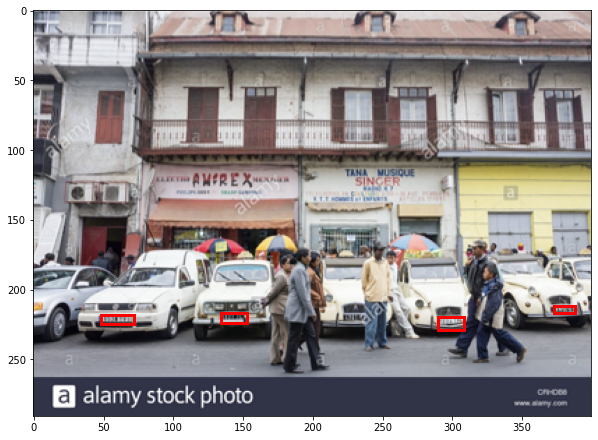

In [25]:
# Open the annotation file and read the contents
with open(os.path.join(TRAIN_LABELS_PATH, 'Cars277.txt')) as f:
    txt_example = f.read()
# Display the content on the screen
print(txt_example)
# Let's look at what the picture itself looks like
plot_bounding_box(TRAIN_IMAGES_PATH, 'Cars277.png', df)

#Training a model

** Model architecture selection: **

You can select a pre-trained YOLOv4 or YOLOv5 model for object detection and fine-tune it for number plate detection. You can download the pre-trained models and their configuration files from the official YOLO website.

In [26]:
#Check that the number of annotations matches the number of images in each sample
print(len(os.listdir(TRAIN_LABELS_PATH)) == len(os.listdir(TRAIN_IMAGES_PATH)))
print(len(os.listdir(VAL_LABELS_PATH)) == len(os.listdir(VAL_IMAGES_PATH)))

True
True


All is ready! We have prepared our dataset for training the YOLOv5 model. As a result, we should have the following folder structure:
```
kaggle
    └─input
        └─car-plate-detection
            └─annotations
            └─images
    └─working
        └─__notebook_source__.ipynb
        └─dataset
            └─dataset.yaml
            └─images
                └─train
                └─val
            └─labels
                └─train
                └─val
```

## Building a detection model

### Clone the repository with the model


Let's clone the repository with YOLOv5 and install the dependencies necessary for it to work:

> Indented block

> Indented block





In [27]:
!pip install cvxpy==1.1.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# Clone the repository with the YOLO-v5 model
!git clone https://github.com/ultralytics/yolov5
# Set the dependencies needed for the model to work
!pip install -qr yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.


As a result of cloning, a yolov5 folder will appear in our working directory (kaggle/working) with a copy of the code for creating and training the model. Let's look at the contents of the yolov5 folder to make sure everything went well:

In [29]:
!ls

'=0.10'    drive	 sample_data   yolov5
 dataset   kaggle.json	 wandb	       yolov5s.pt


In [30]:
!ls yolov5

'=0.10'		   data         models		   runs		    utils
 benchmarks.py	   detect.py    __pycache__	   segment	    val.py
 CITATION.cff	   export.py    README.md	   setup.cfg	    yolov5s.pt
 classify	   hubconf.py   README.zh-CN.md    train.py
 CONTRIBUTING.md   LICENSE      requirements.txt   tutorial.ipynb


Let's go to the directory yolov5 on the system using the command cd. Further work will be done in this folder:

The yolov5 folder contains files from the repository, in particular, we may be interested in the following folders/scripts:
* data - folder with some classic datasets
* models - a folder with the pre-trained model weights that can be used not to train model from scratch
* train.py - script for teaching the model
* val.py - script for model validation
* tutorial.ipynb - a notebook with a tutorial on how to use the model
* utils - module with useful utilities we may need when working with the model

Let's fix the sensor of random number generator in order to get reproducible results in the future. To do this, there is function init_seeds() in yolov5 repository in module utils.general, in which you should pass any number. In order to call this function correctly, you need to go to the yolov5 directory and call the function from there. To move between directories we will use function [os.chdir()](https://docs-python.ru/standart-library/modul-os-python/funktsija-chdir-modulja-os/) from module os.

By tradition we will take 42 as random_state. After fixing all random number generators, we return to the initial working directory.

In [60]:
import os
# Move to the directory yolov5
os.chdir('yolov5')
# Import init_seeds function from there
from utils.general import init_seeds
#Fix a random number generator to reproduce the results
RANDOM_STATE = 42
init_seeds(RANDOM_STATE)
# go back to the working directory
os.chdir('../')

None


During the training of the YOLOv5 model, the implementation from Ultralitics uses the Weights&Bias (W&B) tool to save the training process. [Weights&Bias](https://docs.wandb.ai/) is a machine learning platform that allows developers to build better models faster and track their qualities. It allows you to use lightweight, interoperable W&B tools for quickly tracking experiments, versifying and iterating datasets, evaluating model performance, reproducing models, visualizing results and identifying regressions, and sharing results with colleagues.

In [32]:
#!pip install -q wandb --upgrade

import wandb
wandb.login(anonymous='must')

wandb: Currently logged in as: anony-mouse-503643. Use `wandb login --relogin` to force relogin


True

We can now use the model and retrain it for our task on a given dataset.

### Training the model

The train.py script is used to train the model in the yolov5 repository. To run it, you must specify the following keys:

* `--img` - the size of the image supplied to the YOLOv5 input. This means that the size of the original image is converted to the form $n x n$, where $n$ is the number entered by the user after the -img key;

    **Important:**
    $n$ must be a multiple of 32 (this is due to the YOLOv5 architecture). 32 in this case is the size of one segment, which we talked about when we discussed the general idea of ​​YOLO.
* `--batch` - batch size, that is, the number of images fed to the network in one training step;
* `--epochs` - the number of training epochs, sets how many times the dataset will be passed through the neural network to train it;
* `--data` is the path to the .yaml file that we created above;
* `--weights` - pre-trained weights used by the model;
* `--name` - the name of the folder where we save the learning results.

The `--weights` key is responsible for choosing a pre-trained model.

In practice, we almost always use a model pre-trained on another dataset and adapt it to our task. In particular, the YOLOv5 model is pre-trained on the popular COCO dataset, which you can read about [here](https://cocodataset.org/#home). This is a dataset that uses 80 different classes from humans and dogs to airplanes and cars.

Of course, our (vehicle license plate) will not be found among these classes, however, we can use the patterns and templates learned during training on the COCO dataset and adapt them to our task. This approach is called **Transfer Learning**.

For YOLOv5, there are several possible options for pre-trained weights depending on the size of the models. You can see their list and characteristics (size in megabytes, learning rate and average mAP quality metric on the COCO dataset) below:

<img src= "https://github.com/ultralytics/yolov5/releases/download/v1.0/model_comparison.png" width="50%" align="center" hspace="5%" vspace="5 %"/>

Let's start training:

In [58]:
# Run the train.py file with the script to train the model

!python yolov5/train.py \
--img 640 \
--batch 10 \
--epochs 30 \
--data {DATA_CONFIG_PATH} \
--weights yolov5s.pt \
--name my_yolov5_model_s

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: anony-mouse-503643. Use `wandb login --relogin` to force relogin
usage: train.py
       [-h]
       [--weights WEIGHTS]
       [--cfg CFG]
       [--data DATA]
       [--hyp HYP]
       [--epochs EPOCHS]
       [--batch-size BATCH_SIZE]
       [--imgsz IMGSZ]
       [--rect]
       [--resume [RESUME]]
       [--nosave]
       [--noval]
       [--noautoanchor]
       [--noplots]
       [--evolve [EVOLVE]]
       [--bucket BUCKET]
       [--cache [CACHE]]
       [--image-weights]
       [--device DEVICE]
       [--multi-scale]
       [--single-cls]
       [--optimizer {SGD,Adam,AdamW}]
       [--sync-bn]
       [--workers WORKERS]
       [--project PROJECT]
       [--name NAME]
       [--exist-ok]
       [--quad]
       [--cos-lr]
       [--label-smoothing LABEL_SMOOTHING]
       [--patience PATIENC

**Note:**
*Please note that all training results are saved in runs/train/directories as the number of runs increases. That is, the results of the first run will be saved in the directory `my_yolov5_model_s`, the second in the directory `my_yolov5_model_s2`, the third in `my_yolov5_model_s3`, etc. Be careful when you start training several times in a row!

The learning process has started! Let's wait for its completion (this may take some time). And while the model is learning, let's discuss the main indicators that you should pay attention to during its training:

The output first contains information about the optimizer, training and validation datasets, as well as training parameters, such as the size of the input image, the number of threads, the directory with training results.

Next is information about the training process itself. There are three loss functions:
* `box_loss` - regression loss function in the bounding box (root mean square error - MSE, calculated with respect to the predicted and true coordinates of the bounding box). 

    The closer this value is to 0, the better the model determines the bounding box coordinates.
* `obj_loss` - confidence in the presence of an object is a loss of objectivity.

    The closer this indicator is to 0, the more confident the model determines the object's location.
* `cls_loss` - loss of classification (cross entropy), determines how well the model distinguishes classes from each other.

    The closer this indicator is to 0, the better the model distinguishes classes from each other. 

Next come the metrics indices. Here we should pay attention to columns `P`, `R`, `mAP@.5` and `mAP@.5:.95` - they contain values of metrics precision, recall and two variants of metric mAP respectively. We are not going to dwell on these metrics now, you can read them [here] (https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173). We should only mention that all metrics are measured from 0 to 1, the closer to 1, the better.

[link text](https://)#### Validate the model

When the model finishes its training, the console will indicate where the final results will be saved.

[link text](https://)In this folder will be saved the training history of our model in the form of csv files and various graphs in the format. Let's have a look:

In [51]:
!ls /content/drive/MyDrive/Colab Notebooks/cars_number_plate/train/my_yolov5_model_s/

ls: cannot access '/content/drive/MyDrive/Colab': No such file or directory
ls: cannot access 'Notebooks/cars_number_plate/train/my_yolov5_model_s/': No such file or directory


[link text](https://)Let's look at the graphs, the most general information of interest to us is contained in the file results.png.

The runs/result/weights folder contains 2 files with weights (neural network parameters):
* best.pt - the file with the best variant of the model's parameters for the whole training period
* last.pt - the file where weights obtained by the model at the last epoch of training are saved


**Note:**

*The best model is not always (almost never) the last one!

In [43]:
!ls yolov5/runs/train/my_yolov5_model_s/weights

Let's load the best weights into our model. 

To do this, the hub module of the pytorch library has the load() function. This function allows PyTorch to automatically load models from repositories on GitHub or from local directories and "populate" them with parameter values from files:
* repo_or_dir is the path to the directory and repository where the model is stored. In our case this is the directory where the repository is stored - yolov5;
* model - model name. In YOLOv5, all custom models are referred to as 'custom';
* path - the path to the model weights. Specify the path to the file best.pt; 
* source - source, can be 'local' if the model is taken from local directory or 'github' if the model is downloaded from github. 
    We have everything already uploaded to the working folder, so we put 'local'.

In [45]:
#The way to the place where the best weights are kept
BEST_WEIGHTS_PATH = '/content/drive/MyDrive/Colab Notebooks/cars_number_plate/train/my_yolov5_model_s/weights/best.pt'
# Загружаем лучшие веса
yolov5 = torch.hub.load(
    repo_or_dir='yolov5',
    model='custom',
    path=BEST_WEIGHTS_PATH,
    source='local'
)

YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)



Exception: ignored

Давайте проверим работу нашей лучшей модели, возьмем какую-нибудь картинку и подадим ее на вход модели. Для этого достаточно воспользоваться объектом yolov5 как функцией, передав в качестве ее параметра путь до файла. Можно сразу же отобразить результат, для этого просто вызовем метод show(): 

In [ ]:
# Путь до изображения
image_filename = 'Cars351.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Пропускаем картинку через модель
prediction = yolov5(image_path)
# Отображаем результат
prediction.show()

Число, рядом с именем класса называется confidence. **Confidence** измеряется от 0 до 1 и характеризует «уверенность» модели в том, что данный объект является объектом определенного класса. Иначе говоря - это вероятность того, что в заданном bounding box'е содержится объект указанного класса.

In [ ]:
# Путь до изображения
image_filename = 'Cars352.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Пропускаем картинку через модель
prediction = yolov5(image_path)
# Отображаем результат
prediction.show()

Полученный результат довольно легко конвертировать в DataFrame, для этого YOLOv5 предоставляет функциональность в виде метода pandas():

In [ ]:
# Путь до изображения
image_filename = 'Cars352.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Пропускаем картинку через модель
prediction = yolov5(image_path)
# Конвертируем результат в DataFrame:
prediction.pandas().xyxy[0]

> **Примечание:**

    Важно отметить, что мы можем самостоятельно отсекать такие bounding box’ы, доверие к которым меньше некоторой константы (confidence_rate), тем самым влияя на итоговые метрики precision и recall нашей модели в продакшене. 

    Например, если нам нужно распознавать как можно больше (recall) номерных знаков и ложные срабатывания нам не так страшны (например, при контроле трафика на дорогах), то мы можем взять низкий уровень доверия. Тем самым мы увеличиваем recall.

    Если же нам нужно как можно точнее (precision) определять номерные знаки, игнорируя шумы, (например, на платных парковках) то мы повысим пороговое значение доверия. 

    Как мы знаем,  для идеальной модели и precision и recall равны 1, но идеальных моделей не бывает. Поиск оптимального для вашей задачи порога доверия - это отдельная проблема, решение которой индивидуально для каждой конкретной системы.


По полученным координатам можно вручную реализовать вырезку изображений с номерными знаками из исходных. Однако, и тут разработчики YOLOv5 позаботились об этом за нас.

Модель поддерживает встроенный метод crop(). Данный метод возвращает список из словарей, каждый словарь характеризуем отдельно-взятый bounding box - его координаты (ключ "box"), уровень доверия (ключ "confidence"), номер класса объекта (ключ "class"), название класса (ключ "label") и собственно само вырезанное изображение (ключ "im").

Давайте посмотрим пример вырезки. Будем отсекать такие вырезки, доверие к которым < 0.7:


In [ ]:
# Путь до изображения
image_filename = 'Cars351.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Пропускаем картинку через модель
prediction = yolov5(image_path)
# Делаем вырезки из изображения
croped = prediction.crop()
# Создаем цикл по каждой вырезке
for pred in croped:
    # Отсекаем такие bounding box'ы, доверие к которым < 0.7
    if pred['conf'] < 0.7:
        continue
    # Достаем вырезанное изображение
    img_croped = pred['im']
    # Визуализируем результат
    fig = plt.figure()
    plt.imshow(img_croped)

Отлично, выглядит довольно неплохо! 

Нам остался финальный шаг - давайте упакуем предсказания модели для каждого изображения из исходного датасета в виде таблицы.


Для этого организуем цикл по всем изображениям из датасета и сконкатенируем все предсказания в один DataFrame. Будем отсекать такие bounding box’ы, для которых доля уверенности (confidence) < 0.7. 


In [ ]:
# Список всех файлов с изображениями
filenames = df['filename']
# Создаем пустой DataFrame
pred_df = pd.DataFrame()
# Создаем цикл по всем файлами
for filename in tqdm(filenames):
    # Составляем путь до изображения
    image_path = os.path.join(IMAGES_PATH, filename)
    # Пропускаем изображение через модель
    prediction = yolov5(image_path)
    # Конвертируем предсказания в DataFrame
    pred_rows = prediction.pandas().xyxy[0]
    # Оставляем bounding box'ы, доверие к которым > 0.7
    pred_rows = pred_rows[pred_rows['confidence'] > 0.7]
    # Добавляем в DataFrame столбец с именем файла для ясности
    pred_rows['filename'] = filename
    # Конкатенируем полученный DataFrame к общей таблице
    pred_df = pred_df.append(pred_rows)
# Сбрасываем индекс
pred_df = pred_df.reset_index(drop=True)    
pred_df.head()

In [ ]:
print(pred_df.shape)

Можно сохранить DataFrame с предсказанными координатами bounding box’ов как один из артефактов вашей работы, чтобы впоследствии проанализировать результаты.


In [ ]:
#Сохраняем полученные предсказания в виде таблицы
pred_df.to_csv('dataset/yolov5_predictions.csv', index=False)

Можно визуализировать несколько эталонных и предсказанных bounding box'ов и оценить результаты

In [ ]:
# count = 3
# for i in range(count):
#     random_image_idx = np.random.choice(df.shape[0])
#     image_filename = df.loc[random_image_idx, 'filename']
#     plot_bounding_box(IMAGES_PATH, image_filename, df)
#     plot_bounding_box(IMAGES_PATH, image_filename, pred_df)

Не забудьте сохранить все артефакты (файлы с данными и весами модели), которые мы получили в процессе исполнения кода в ноутбуке. Это важно сделать, так как в противном случае после выхода из Kaggle-ноутбука все файлы будут удалены и вам придется запускать процесс предобработки данных и обучения заново, чтобы получить модель.


По итогу этого этапа нашей работы нам останется отдать файл с весами нашей обученной модели команде разработчиков нашей ALPR-системы, чтобы они на ее базе смогли решать задачи обнаружения номерных знаков по изображениям с камер видеонаблюдения!